In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import stochrare as sr
import sys
sys.path.insert(1, '../ERA')
from ERA_Fields import*
np.random.seed(seed=100)

def func0(x, a, b):
    return a * np.exp(b * x)
def func1(x, a, b, c, d):
    return a * np.exp(b * x) + c * np.exp(d * x) 
def PltAutocorrelationFit0(autocorr_mean,autocorr_std,x1,x2, ax,period_label):
    # Plot normalized Autocorrelation function
    plt.plot(np.arange(0, len(autocorr_mean)), autocorr_mean,'b:', label=r'$\int C(t) dt$ = %5.1f d'%(integrate.cumtrapz(np.array(autocorr_mean), range(len(autocorr_mean)), initial=0)[-1]))
    #plt.plot(np.arange(0, len(autocorr_mean)), -autocorr_mean,'k:', label='- autocorrelation')
    popt1, pcov1 = curve_fit(func0, np.array(range(x1,x2)), autocorr_mean[x1:x2], p0=(1, 1e-6))
    xaxis1 = np.arange(x1,x2)
    plt.plot(xaxis1, func0(xaxis1, *popt1), 'r--', label=r'A= %5.3f$\quad$-slope$^{-1}_1$ = %5.1f ' %(popt1[0],-popt1[1]**(-1)))

    plt.title(period_label+r": $\Sigma_y \Sigma_t  \alpha(t) \alpha(t+\tau)/N(\tau)$")
    plt.yscale("log")
    plt.xlabel(r"Lag $\tau$")

def PltAutocorrelationFit(autocorr_mean,autocorr_std,x1,x2, ax,period_label):
    # Plot normalized Autocorrelation function
    plt.plot(np.arange(0, len(autocorr_mean)), autocorr_mean,'b:', label=r'$\int C(t) dt$ = %5.1f d'%(integrate.cumtrapz(np.array(autocorr_mean), range(len(autocorr_mean)), initial=0)[-1]))
    plt.plot(np.arange(0, len(autocorr_mean)), -autocorr_mean,'k:', label='- autocorrelation')
    
    popt1, pcov1 = curve_fit(func1, np.array(range(x1,x2)), autocorr_mean[x1:x2], p0=(1, 1e-6, 1, 1e-6))
    xaxis1 = np.arange(x1,x2)
    plt.plot(xaxis1, func1(xaxis1, *popt1), 'r--', label=r'A= %5.3f,$\quad$ B= %5.3f,$\quad$-slope$^{-1}_1$ = %5.1f ,$\quad$-slope$^{-2}_2$ = %5.1f  ' %(popt1[0],popt1[2],-popt1[1]**(-1),-popt1[3]**(-1)))

    plt.title(period_label+r": $\Sigma_y \Sigma_t  \alpha(t) \alpha(t+\tau)/N(\tau)$")
    plt.yscale("log")
    plt.xlabel(r"Lag $\tau$")
    
def PltAutocorrelation(series_reshape,ax,myperiod_label):
    myfiglabels = ['111']
    myfirst = [Tot_Mon1[6]]
    mylast = [Tot_Mon1[9]]
    for first, last, period_label, figlabels in zip(myfirst, mylast, myperiod_label, myfiglabels):
        autocorr = []
        for i in range(10):
            autocorr.append(autocorrelation(series_reshape[i*100:(i+1)*100,first:last],last-first))
        autocorr = np.array(autocorr)#/np.std(t2m.abs_area_int[i*100:(i+1)*100,first:last])**2
        print(autocorr.shape)
        autocorr_mean = np.mean(autocorr,0)
        autocorr_std = np.std(autocorr,0)
        np.save('Postproc/OU_nonorm_autocorr_mean_'+period_label,autocorr_mean)
        np.save('Postproc/OU_nonorm_autocorr_std_'+period_label,autocorr_std)
        print(autocorr_mean.shape,autocorr_std.shape)
        plt.fill_between(np.arange(0, len(autocorr_mean)), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='yellow')
        full_auto = autocorrelation(series_reshape.reshape(1,-1),100)
        plt.plot(full_auto,label='Gaussian')
        return autocorr_mean, autocorr_std
        
def ProcTimeAverage(series_reshape,Tot_Mon1, modified='no'):
    A = np.zeros((series_reshape.shape[0], Tot_Mon1[9] - Tot_Mon1[6]  - 13))  # When we use convolve (running mean) there is an extra point that we can generate by displacing the window hence 13 instead of 14
    convseq = np.ones(14)/14
    for y in range(series_reshape.shape[0]):
        A[y,:]=np.convolve(series_reshape[y,(Tot_Mon1[6]):(Tot_Mon1[9])],  convseq, mode='valid')
    print("A.shape = ", A.shape)
    print("np.std(A) = ",np.std(A))
    A_max, Ti, year_a = a_max_and_ti_postproc(A, A.shape[1])
    year_a = range(series_reshape.shape[0])
    A_max_sorted = a_decrese(A_max, Ti, year_a)
    XX_rt, YY_rt, xx_rt, yy_rt = return_time_fix(A_max_sorted, modified)
    return XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted
    
    
def GaussianProc(A, tau, N, num_years):
    D = A/tau
    t0 = 0
    x0 = 0
    oup = sr.dynamics.diffusion1d.ConstantDiffusionProcess1D(lambda x, t: -x/tau, D)
    reftraj = oup.trajectory(x0, t0, T=N)
    times = np.convolve(reftraj[0], np.ones(10)/10, mode='valid')[1:reftraj[1].shape[0]:10]
    series = np.convolve(reftraj[1], np.ones(10)/10, mode='valid')[1:reftraj[1].shape[0]:10]
    print("np.mean(series)  = ", np.mean(series), "np.std(series) = ", np.std(series))
    return series.reshape((num_years,-1))

def GaussianProcInstant(A, tau, N, num_years):
    D = A/tau
    t0 = 0
    x0 = 0
    oup = sr.dynamics.diffusion1d.ConstantDiffusionProcess1D(lambda x, t: -x/tau, D)
    reftraj = oup.trajectory(x0, t0, T=N)
    times = reftraj[0][1:reftraj[1].shape[0]:10]
    series = reftraj[1][1:reftraj[1].shape[0]:10]
    print("np.mean(series)  = ", np.mean(series), "np.std(series) = ", np.std(series))
    return series.reshape((num_years,-1))

def Bootstraps(series_reshape,FROM,Tot_Mon1,area,ax, modified='no'):
    for T in [5,14,30,90]:
        Model_XX_rt = np.load('../'+FROM+'/Postproc/'+FROM+'_'+area+'_XX_rt_'+str(T)+'.npy')
        Model_YY_mean = np.load('../'+FROM+'/Postproc/'+FROM+'_'+area+'_YY_mean_'+str(T)+'.npy')
        Model_YY_std = np.load('../'+FROM+'/Postproc/'+FROM+'_'+area+'_YY_std_'+str(T)+'.npy')
        plt.fill_between(Model_XX_rt, Model_YY_mean-Model_YY_std, Model_YY_mean+Model_YY_std,label=str(T)+' days ('+FROM+')',alpha=0.5)
    for T, mycolor in zip([5,14,30,90],['blue','orange','green','red']):
        convseq = np.ones(T)/T
        print("T = ",T)
        A = np.zeros((1000, Tot_Mon1[9] - Tot_Mon1[6]  - T+1))   # When we use convolve (running mean) there is an extra point that we can generate by displacing the window hence 13 instead of 14
        for y in range(1000):
            A[y,:]=np.convolve(series_reshape[y,:],  convseq, mode='valid')
        print("A.shape = ", A.shape)
        print("np.std(A) = ",np.std(A))
        A_max, Ti, year_a = a_max_and_ti_postproc(A, A.shape[1])
        year_a = range(1000)
        A_max_sorted = a_decrese(A_max, Ti, year_a)
        XX_rt, YY_rt, xx_rt, yy_rt = return_time_fix(A_max_sorted, modified)

        plt.scatter(XX_rt[10:], YY_rt[10:], s=15, marker='x', color='black')
        plt.scatter(XX_rt[10:], YY_rt[10:], s=7, marker='x', color=mycolor)#,label=str(T)+' days ('+FROM+')')
        #lt.scatter(XX_rt[10:], YY_rt[10:],label=str(T)+' days (Gaussian)',marker=',',s=2)
        #ERA_XX_rt = np.load('../CDS/ERA_'+area+'_XX_rt_'+str(T)+'.npy')
        #ERA_YY_rt = np.load('../CDS/ERA_'+area+'_YY_rt_'+str(T)+'.npy')
        #plt.scatter(ERA_XX_rt,  ERA_YY_rt, s=10, marker='x',label=str(T)+' days (ERA5)')

    ax.set_xscale('log')
    ax.set_xlim([1, 100])
    ax.set_ylim([-1, 10])
    ax.legend(loc='best')
    ax.set_xlabel(r'return time $\hat{r}$ (year)')
    ax.set_ylabel(r'temperature anomaly threshold $a_r$ (K)')
    #ax.set_title('Temperature anomalies over '+ area, loc='left')
    
def Returns(series_reshape,FROM,Tot_Mon1,area,ax, modified='no'):
    for T in [5,14,30,90]:
        Model_XX_rt = np.load('../'+FROM+'/Postproc/'+FROM+'_'+area+'_XX_rt_'+str(T)+'.npy')
        Model_YY_rt = np.load('../'+FROM+'/Postproc/'+FROM+'_'+area+'_YY_rt_'+str(T)+'.npy')
        plt.scatter(Model_XX_rt, Model_YY_rt,label=str(T)+' days ('+FROM+')',marker='*',s=2)
    for T in [5,14,30,90]:
        convseq = np.ones(T)/T
        print("T = ",T)
        A = np.zeros((1000, Tot_Mon1[9] - Tot_Mon1[6]  - T+1))   # When we use convolve (running mean) there is an extra point that we can generate by displacing the window hence 13 instead of 14
        for y in range(1000):
            A[y,:]=np.convolve(series_reshape[y,:],  convseq, mode='valid')
        print("A.shape = ", A.shape)
        print("np.std(A) = ",np.std(A))
        A_max, Ti, year_a = a_max_and_ti_postproc(A, A.shape[1])
        year_a = range(1000)
        A_max_sorted = a_decrese(A_max, Ti, year_a)
        XX_rt, YY_rt, xx_rt, yy_rt = return_time_fix(A_max_sorted, modified)


        plt.scatter(XX_rt[10:], YY_rt[10:],label=str(T)+' days (Gaussian)',marker=',',s=2)
        #ERA_XX_rt = np.load('../CDS/ERA_'+area+'_XX_rt_'+str(T)+'.npy')
        #ERA_YY_rt = np.load('../CDS/ERA_'+area+'_YY_rt_'+str(T)+'.npy')
        #plt.scatter(ERA_XX_rt,  ERA_YY_rt, s=10, marker='x',label=str(T)+' days (ERA5)')

    ax.set_xscale('log')
    ax.set_xlim([1, 100])
    #ax.set_ylim([-2, 6])
    ax.legend(loc='best')
    ax.set_xlabel(r'return time $\hat{r}$ (year)')
    ax.set_ylabel(r'temperature anomaly threshold $a_r$ (K)')
    #ax.set_title('Temperature anomalies over '+ area, loc='left')

Trying to import basemap
Successfully imported basemap


# PlaSim
## France

Below we will try to reproduce the curves of PlaSim France by fixing the variance to the original data (orange curve) and choosing 18.6 for the time scale (which is integral time scale from the actual data)

np.mean(series)  =  0.010646768 np.std(series) =  2.795826
series.shape =  (1000, 100)
(10, 100)
(100,) (100,)
A.shape =  (1000, 87)
np.std(A) =  2.4191856318315907


../ERA/ERA_Fields.py:792: UserWarning: a_max_and_ti_postproc: adjusting length
  warnings.warn('a_max_and_ti_postproc: adjusting length')
../ERA/ERA_Fields.py:764: RuntimeWarning: divide by zero encountered in log
  r1 = - 1/(np.log(1 - m/len(D_sorted))) # assumption of Poisson process


T =  5
A.shape =  (1000, 96)
np.std(A) =  2.651717289762342
T =  14
A.shape =  (1000, 87)
np.std(A) =  2.4191856318315907
T =  30
A.shape =  (1000, 71)
np.std(A) =  2.103784793980121
T =  90
A.shape =  (1000, 11)
np.std(A) =  1.489236820379878
CPU times: user 1.83 s, sys: 413 ms, total: 2.24 s
Wall time: 1.95 s


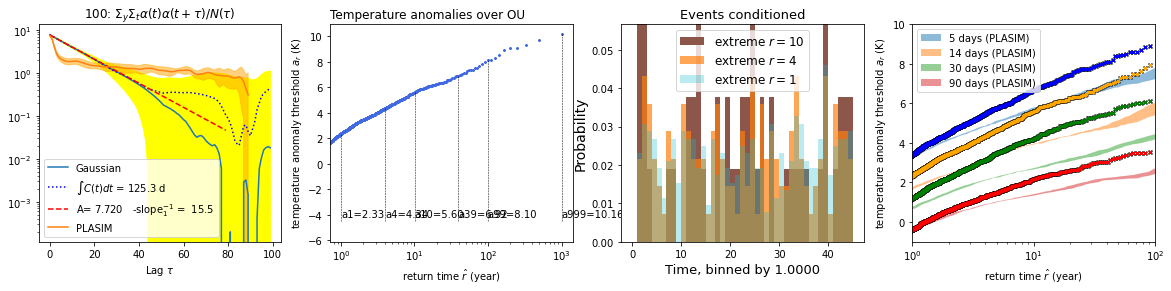

In [2]:
%%time

#series_reshape = GaussianProcInstant(6., 35., 1e5,1000)
#series_reshape = GaussianProcInstant(5.648+2.453, 18.6, 1e5,1000)
series_reshape = GaussianProcInstant(6.008+1.854, 14.9, 1e5,1000)
#series_reshape = GaussianProcInstant(6.008, 18.6, 1e5,1000)
print("series.shape = ", series_reshape.shape)

Months1 = [0, 0, 0, 0, 0, 0, 0, 30, 30, 40, 0, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(itertools.accumulate(Months1))
period_label = '100'
FROM = 'PLASIM'
TO = 'OU'
area = 'France'
figure = plt.figure(1, figsize=(20, 4))
ax = figure.add_subplot(141)
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)
PltAutocorrelationFit0(autocorr_mean,autocorr_std,0,80,ax,period_label)   
autocorr_mean = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_mean_JJA.npy')
autocorr_std = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_std_JJA.npy')
plt.fill_between(np.arange(0, len(autocorr_mean)), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='orange',alpha=0.5)
plt.plot(autocorr_mean,label=FROM)
plt.legend()

XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted = ProcTimeAverage(series_reshape,Tot_Mon1,'yes')
ax2 = figure.add_subplot(142)
ax3 = figure.add_subplot(143)
PltReturnsHist(XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted, Tot_Mon1,TO,ax2,ax3)

ax4 = figure.add_subplot(144)
#BootstrapReturnsOnly(series_reshape, area, Tot_Mon1, area, ax4)
Bootstraps(series_reshape,FROM,Tot_Mon1,area,ax4,'yes')
ax4.legend(loc='best')
figure.savefig("Images/autocorelation_1timescale_"+FROM+"_"+area+".png")
extent = ax4.get_window_extent().transformed(figure.dpi_scale_trans.inverted())
figure.savefig("Images/autocorelation_OU_"+FROM+"_"+area+"_single_scale.png", bbox_inches=extent.expanded(1.4, 1.4),dpi=200)

In [14]:
series_reshape.reshape(1,-1).shape

(1, 100000)

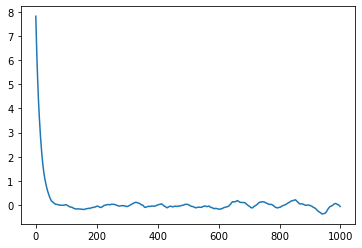

In [16]:
plt.plot(autocorrelation(series_reshape.reshape(1,-1),1000))

(10, 100)
(100,) (100,)


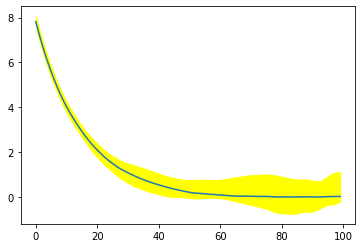

In [5]:
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)

In [ ]:
def PltAutocorrelation(series_reshape,ax,myperiod_label):
    myfiglabels = ['111']
    myfirst = [Tot_Mon1[6]]
    mylast = [Tot_Mon1[9]]
    for first, last, period_label, figlabels in zip(myfirst, mylast, myperiod_label, myfiglabels):
        autocorr = []
        for i in range(10):
            autocorr.append(autocorrelation(series_reshape[i*100:(i+1)*100,first:last],last-first))
        autocorr = np.array(autocorr)#/np.std(t2m.abs_area_int[i*100:(i+1)*100,first:last])**2
        print(autocorr.shape)
        autocorr_mean = np.mean(autocorr,0)
        autocorr_std = np.std(autocorr,0)
        np.save('Postproc/OU_nonorm_autocorr_mean_'+period_label,autocorr_mean)
        np.save('Postproc/OU_nonorm_autocorr_std_'+period_label,autocorr_std)
        print(autocorr_mean.shape,autocorr_std.shape)
        plt.fill_between(np.arange(0, len(autocorr_mean)), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='yellow')
        full_auto = autocorrelation(series_reshape.reshape(1,-1),100)
        plt.plot(full_auto,label='Gaussian')
        return autocorr_mean, autocorr_std

Below we will fit using precise fit parameters

np.mean(series)  =  0.009533239 np.std(series) =  2.4673023
np.mean(series)  =  0.02539673 np.std(series) =  1.3345279
series.shape =  (1000, 100)
(10, 100)
(100,) (100,)
A.shape =  (1000, 87)
np.std(A) =  1.8096462400213975


../ERA/ERA_Fields.py:792: UserWarning: a_max_and_ti_postproc: adjusting length
  warnings.warn('a_max_and_ti_postproc: adjusting length')
../ERA/ERA_Fields.py:764: RuntimeWarning: divide by zero encountered in log
  r1 = - 1/(np.log(1 - m/len(D_sorted))) # assumption of Poisson process


T =  5
A.shape =  (1000, 96)
np.std(A) =  2.239321595807813
T =  14
A.shape =  (1000, 87)
np.std(A) =  1.8096462400213975
T =  30
A.shape =  (1000, 71)
np.std(A) =  1.5525737904546544
T =  90
A.shape =  (1000, 11)
np.std(A) =  1.2672981061923918
CPU times: user 1.56 s, sys: 398 ms, total: 1.96 s
Wall time: 1.55 s


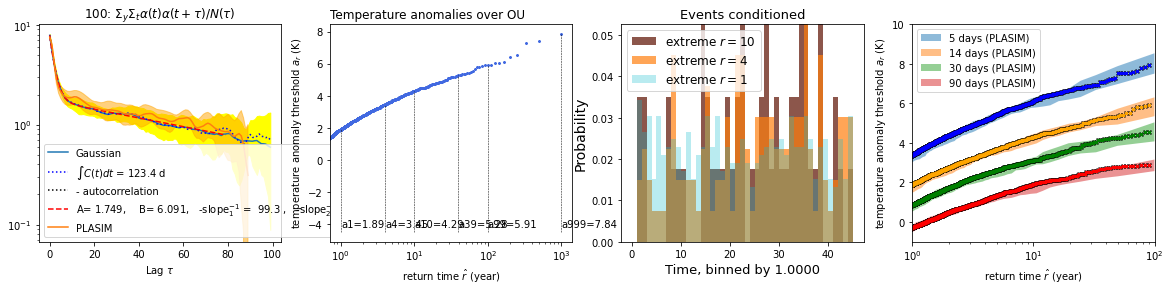

In [26]:
%%time
series_reshape = GaussianProcInstant(6.008, 2.1, 1e5,1000)+GaussianProcInstant(1.854, 108.4, 1e5,1000)
#series_reshape = GaussianProcInstant(5.648, 2.1, 1e5,1000)+GaussianProcInstant(2.453, 114, 1e5,1000)
print("series.shape = ", series_reshape.shape)

Months1 = [0, 0, 0, 0, 0, 0, 0, 30, 30, 40, 0, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(itertools.accumulate(Months1))
period_label = '100'
FROM = 'PLASIM'
TO = 'OU'
area = 'France'
figure = plt.figure(1, figsize=(20, 4))
ax = figure.add_subplot(141)
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)
PltAutocorrelationFit(autocorr_mean,autocorr_std,0,80,ax,period_label)   
autocorr_mean = np.load('../'+FROM+'/Postproc/Plasim_'+area+'_nonorm_autocorr_mean_JJA.npy')
autocorr_std = np.load('../'+FROM+'/Postproc/Plasim_'+area+'_nonorm_autocorr_std_JJA.npy')
plt.fill_between(np.arange(0, len(autocorr_mean)), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='orange',alpha=0.5)
plt.plot(autocorr_mean,label=FROM)
plt.legend()

XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted = ProcTimeAverage(series_reshape,Tot_Mon1,'yes')
ax2 = figure.add_subplot(142)
ax3 = figure.add_subplot(143)
PltReturnsHist(XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted, Tot_Mon1,TO,ax2,ax3)

ax4 = figure.add_subplot(144)
#BootstrapReturnsOnly(series_reshape, area, Tot_Mon1, area, ax4)
Bootstraps(series_reshape,FROM,Tot_Mon1,area,ax4,'yes')
ax4.legend(loc='best')
figure.savefig("Images/autocorelation_2timescales_"+FROM+"_"+area+".png")
extent = ax4.get_window_extent().transformed(figure.dpi_scale_trans.inverted())
figure.savefig("Images/autocorelation_OU_"+FROM+"_"+area+".png", bbox_inches=extent.expanded(1.4, 1.4),dpi=200)

np.mean(series)  =  0.01164912 np.std(series) =  2.3970914
np.mean(series)  =  -0.051047955 np.std(series) =  1.509509
series.shape =  (1000, 100)
(10, 100)
(100,) (100,)
A.shape =  (1000, 87)
np.std(A) =  1.8913223153486314


../ERA/ERA_Fields.py:534: RuntimeWarning: divide by zero encountered in log
  r1 = - 1/(np.log(1 - m/len(D_sorted)))


T =  5
A.shape =  (1000, 96)
np.std(A) =  2.285514693739632
T =  14
A.shape =  (1000, 87)
np.std(A) =  1.8913223153486314
T =  30
A.shape =  (1000, 71)
np.std(A) =  1.6720162559817973
T =  90
A.shape =  (1000, 11)
np.std(A) =  1.4022050817840506
CPU times: user 1.45 s, sys: 4.02 ms, total: 1.45 s
Wall time: 1.5 s


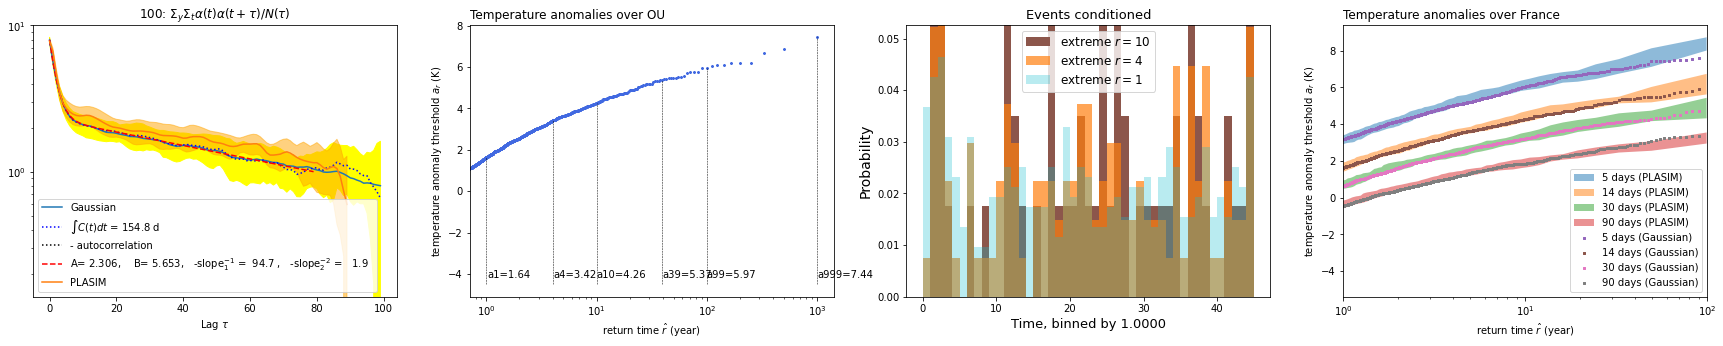

In [60]:
%%time
#series_reshape = GaussianProcInstant(6.008, 2.1, 1e5,1000)+GaussianProcInstant(1.854, 108.4, 1e5,1000)
series_reshape = GaussianProcInstant(5.648, 2.1, 1e5,1000)+GaussianProcInstant(2.453, 114, 1e5,1000)
print("series.shape = ", series_reshape.shape)

Months1 = [0, 0, 0, 0, 0, 0, 0, 30, 30, 40, 0, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(itertools.accumulate(Months1))
period_label = '100'
FROM = 'PLASIM'
TO = 'OU'
area = 'France'
figure = plt.figure(1, figsize=(30, 5))
ax = figure.add_subplot(141)
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)
PltAutocorrelationFit(autocorr_mean,autocorr_std,0,80,ax,period_label)   
autocorr_mean = np.load('../'+FROM+'/Postproc/Plasim_'+area+'_nonorm_autocorr_mean_JJA.npy')
autocorr_std = np.load('../'+FROM+'/Postproc/Plasim_'+area+'_nonorm_autocorr_std_JJA.npy')
plt.fill_between(np.arange(0, len(autocorr_mean)), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='orange',alpha=0.5)
plt.plot(autocorr_mean,label=FROM)
plt.legend()

XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted = ProcTimeAverage(series_reshape,Tot_Mon1,'yes')
ax2 = figure.add_subplot(142)
ax3 = figure.add_subplot(143)
PltReturnsHist(XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted, Tot_Mon1,TO,ax2,ax3)

ax4 = figure.add_subplot(144)
#BootstrapReturnsOnly(series_reshape, area, Tot_Mon1, area, ax4)
Bootstraps(series_reshape,FROM,Tot_Mon1,area,ax4,'yes')
ax4.legend(loc='best')
figure.savefig("Images/autocorelation_2timescales_"+FROM+"_"+area+".png")
extent = ax4.get_window_extent().transformed(figure.dpi_scale_trans.inverted())
figure.savefig("Images/autocorelation_OU_"+FROM+"_"+area+".png", bbox_inches=extent.expanded(1.3, 1.3))

## Scandinavia

np.mean(series)  =  0.01903328 np.std(series) =  1.440373
np.mean(series)  =  0.015838252 np.std(series) =  0.34586498
series.shape =  (1000, 100)
(10, 100)
(100,) (100,)
A.shape =  (1000, 87)
np.std(A) =  0.8660944538023724


../ERA/ERA_Fields.py:792: UserWarning: a_max_and_ti_postproc: adjusting length
  warnings.warn('a_max_and_ti_postproc: adjusting length')
../ERA/ERA_Fields.py:764: RuntimeWarning: divide by zero encountered in log
  r1 = - 1/(np.log(1 - m/len(D_sorted))) # assumption of Poisson process


T =  5
A.shape =  (1000, 96)
np.std(A) =  1.1645991850544222
T =  14
A.shape =  (1000, 87)
np.std(A) =  0.8660944538023724
T =  30
A.shape =  (1000, 71)
np.std(A) =  0.6551508265204427
T =  90
A.shape =  (1000, 11)
np.std(A) =  0.43579171097182495
CPU times: user 1.63 s, sys: 397 ms, total: 2.03 s
Wall time: 1.63 s


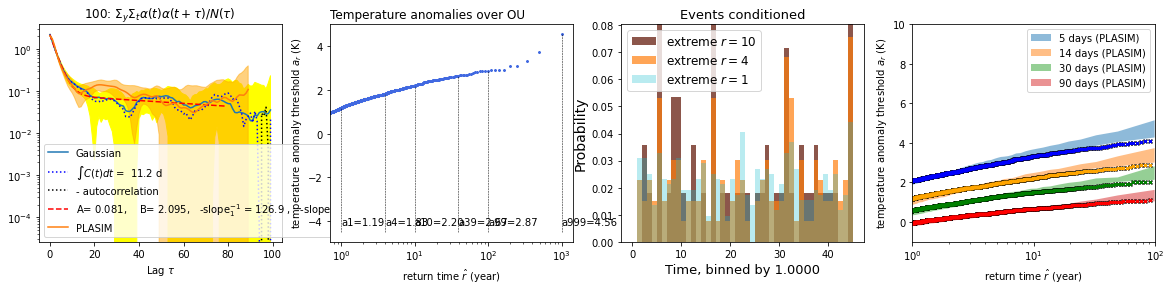

In [27]:
%%time
series_reshape = GaussianProcInstant(2.062, 2.7, 1e5,1000)+GaussianProcInstant(0.125, 82.3, 1e5,1000)
print("series.shape = ", series_reshape.shape)

Months1 = [0, 0, 0, 0, 0, 0, 0, 30, 30, 40, 0, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(itertools.accumulate(Months1))
period_label = '100'
FROM = 'PLASIM'
TO = 'OU'
area = 'Scandinavia'
figure = plt.figure(1, figsize=(20, 4))
ax = figure.add_subplot(141)
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)
PltAutocorrelationFit(autocorr_mean,autocorr_std,0,80,ax,period_label)   
autocorr_mean = np.load('../'+FROM+'/Postproc/Plasim_'+area+'_nonorm_autocorr_mean_JJA.npy')
autocorr_std = np.load('../'+FROM+'/Postproc/Plasim_'+area+'_nonorm_autocorr_std_JJA.npy')
plt.fill_between(np.arange(0, len(autocorr_mean)), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='orange',alpha=0.5)
plt.plot(autocorr_mean,label=FROM)
plt.legend()

XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted = ProcTimeAverage(series_reshape,Tot_Mon1,'yes')
ax2 = figure.add_subplot(142)
ax3 = figure.add_subplot(143)
PltReturnsHist(XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted, Tot_Mon1,TO,ax2,ax3)

ax4 = figure.add_subplot(144)
#BootstrapReturnsOnly(series_reshape, area, Tot_Mon1, area, ax4)
Bootstraps(series_reshape,FROM,Tot_Mon1,area,ax4,'yes')
ax4.legend(loc='best')
figure.savefig("Images/autocorelation_2timescales_"+FROM+"_"+area+".png")
extent = ax4.get_window_extent().transformed(figure.dpi_scale_trans.inverted())
figure.savefig("Images/autocorelation_OU_"+FROM+"_"+area+".png",bbox_inches=extent.expanded(1.4, 1.4),dpi=200)

np.mean(series)  =  0.011585196 np.std(series) =  1.4475548
np.mean(series)  =  0.00438608 np.std(series) =  0.4310636
series.shape =  (1000, 100)
(10, 100)
(100,) (100,)
A.shape =  (1000, 87)
np.std(A) =  0.9109312330608234
T =  5


../ERA/ERA_Fields.py:791: UserWarning: a_max_and_ti_postproc: adjusting length
  warnings.warn('a_max_and_ti_postproc: adjusting length')
../ERA/ERA_Fields.py:763: RuntimeWarning: divide by zero encountered in log
  r1 = - 1/(np.log(1 - m/len(D_sorted))) # assumption of Poisson process


A.shape =  (1000, 96)
np.std(A) =  1.2015718539666596
T =  14
A.shape =  (1000, 87)
np.std(A) =  0.9109312330608234
T =  30
A.shape =  (1000, 71)
np.std(A) =  0.7104116079868943
T =  90
A.shape =  (1000, 11)
np.std(A) =  0.4990404031909243
CPU times: user 1.53 s, sys: 8.06 ms, total: 1.54 s
Wall time: 1.53 s


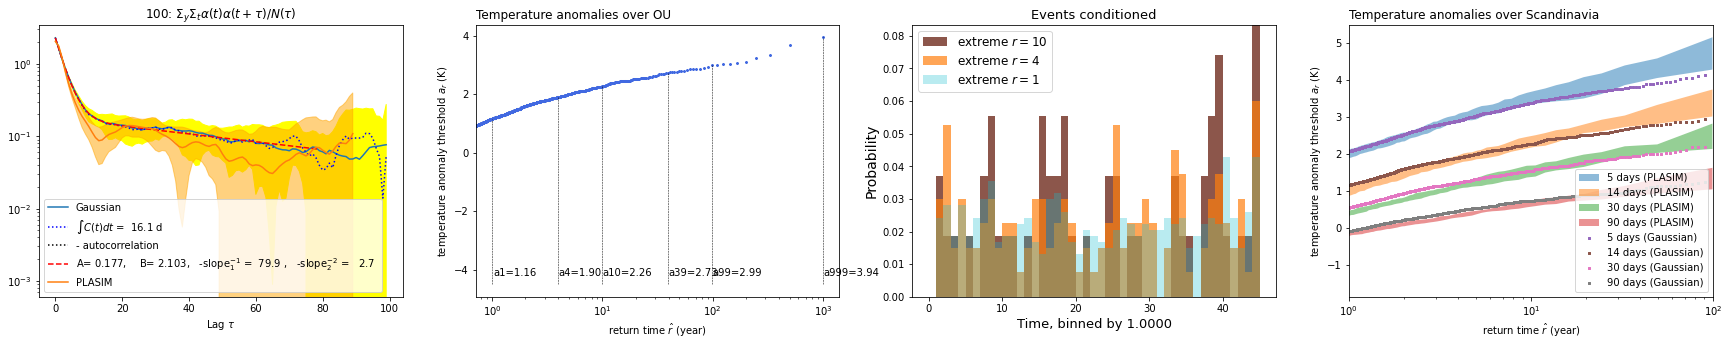

In [21]:
%%time
series_reshape = GaussianProcInstant(2.062, 2.7, 1e5,1000)+GaussianProcInstant(0.2, 82.3, 1e5,1000)
print("series.shape = ", series_reshape.shape)

Months1 = [0, 0, 0, 0, 0, 0, 0, 30, 30, 40, 0, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(itertools.accumulate(Months1))
period_label = '100'
FROM = 'PLASIM'
TO = 'OU'
area = 'Scandinavia'
figure = plt.figure(1, figsize=(30, 5))
ax = figure.add_subplot(141)
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)
PltAutocorrelationFit(autocorr_mean,autocorr_std,0,80,ax,period_label)   
autocorr_mean = np.load('../'+FROM+'/Postproc/Plasim_'+area+'_nonorm_autocorr_mean_JJA.npy')
autocorr_std = np.load('../'+FROM+'/Postproc/Plasim_'+area+'_nonorm_autocorr_std_JJA.npy')
plt.fill_between(np.arange(0, len(autocorr_mean)), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='orange',alpha=0.5)
plt.plot(autocorr_mean,label=FROM)
plt.legend()

XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted = ProcTimeAverage(series_reshape,Tot_Mon1,'yes')
ax2 = figure.add_subplot(142)
ax3 = figure.add_subplot(143)
PltReturnsHist(XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted, Tot_Mon1,TO,ax2,ax3)

ax4 = figure.add_subplot(144)
#BootstrapReturnsOnly(series_reshape, area, Tot_Mon1, area, ax4)
Bootstraps(series_reshape,FROM,Tot_Mon1,area,ax4,'yes')
ax4.legend(loc='best')
figure.savefig("Images/autocorelation_2timescales_"+FROM+"_"+area+".png")
extent = ax4.get_window_extent().transformed(figure.dpi_scale_trans.inverted())
figure.savefig("Images/autocorelation_OU_"+FROM+"_"+area+".png", bbox_inches=extent.expanded(1.3, 1.3))

# CESM
## France

np.mean(series)  =  -0.021799948 np.std(series) =  2.5688057
np.mean(series)  =  -0.050314296 np.std(series) =  0.8121947
series.shape =  (1000, 100)
(10, 100)
(100,) (100,)
A.shape =  (1000, 87)
np.std(A) =  1.7417565399678716


../ERA/ERA_Fields.py:792: UserWarning: a_max_and_ti_postproc: adjusting length
  warnings.warn('a_max_and_ti_postproc: adjusting length')
../ERA/ERA_Fields.py:764: RuntimeWarning: divide by zero encountered in log
  r1 = - 1/(np.log(1 - m/len(D_sorted))) # assumption of Poisson process


T =  5
A.shape =  (1000, 96)
np.std(A) =  2.2346398456812553
T =  14
A.shape =  (1000, 87)
np.std(A) =  1.7417565399678716
T =  30
A.shape =  (1000, 71)
np.std(A) =  1.3536935204399945
T =  90
A.shape =  (1000, 11)
np.std(A) =  0.8985288415916924
CPU times: user 1.67 s, sys: 351 ms, total: 2.02 s
Wall time: 1.6 s


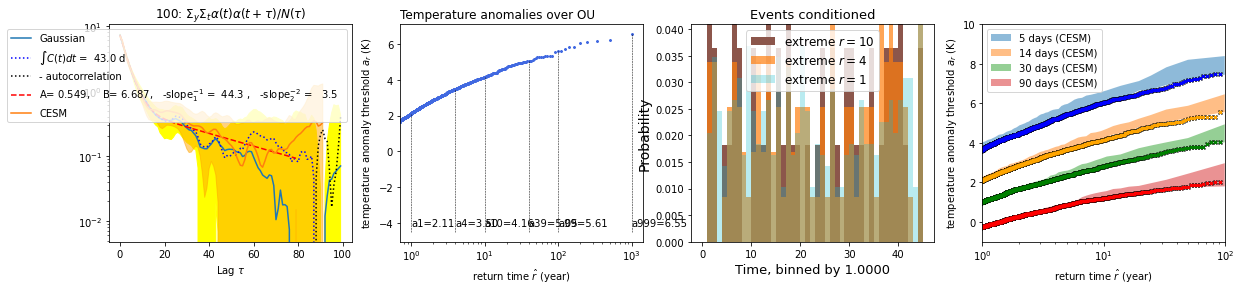

In [28]:
%%time
series_reshape = GaussianProcInstant(6.478, 3.4, 1e5,1000)+GaussianProcInstant(0.69, 38.6, 1e5,1000)
print("series.shape = ", series_reshape.shape)

Months1 = [0, 0, 0, 0, 0, 0, 0, 30, 30, 40, 0, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(itertools.accumulate(Months1))
period_label = '100'
FROM = 'CESM'
TO = 'OU'
area = 'France'
figure = plt.figure(1, figsize=(20, 4))
ax = figure.add_subplot(141)
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)
PltAutocorrelationFit(autocorr_mean,autocorr_std,0,80,ax,period_label)   
autocorr_mean = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_mean_JJA.npy')
autocorr_std = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_std_JJA.npy')
plt.fill_between(np.arange(0, len(autocorr_mean)), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='orange',alpha=0.5)
plt.plot(autocorr_mean,label=FROM)
plt.legend()

XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted = ProcTimeAverage(series_reshape,Tot_Mon1,'yes')
ax2 = figure.add_subplot(142)
ax3 = figure.add_subplot(143)
PltReturnsHist(XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted, Tot_Mon1,TO,ax2,ax3)

ax4 = figure.add_subplot(144)
#BootstrapReturnsOnly(series_reshape, area, Tot_Mon1, area, ax4)
Bootstraps(series_reshape,FROM,Tot_Mon1,area,ax4,'yes')

ax4.legend(loc='best')
figure.savefig("Images/autocorelation_2timescales_"+FROM+"_"+area+".png")
extent = ax4.get_window_extent().transformed(figure.dpi_scale_trans.inverted())
figure.savefig("Images/autocorelation_OU_"+FROM+"_"+area+".png", bbox_inches=extent.expanded(1.4, 1.4),dpi=200)

np.mean(series)  =  -0.019463383 np.std(series) =  2.5581539
np.mean(series)  =  0.016590232 np.std(series) =  0.8425008
series.shape =  (1000, 100)
(10, 100)
(100,) (100,)
A.shape =  (1000, 87)
np.std(A) =  1.737447812916013
T =  5
A.shape =  (1000, 96)
np.std(A) =  2.227834827597871
T =  14


../ERA/ERA_Fields.py:534: RuntimeWarning: divide by zero encountered in log
  r1 = - 1/(np.log(1 - m/len(D_sorted)))


A.shape =  (1000, 87)
np.std(A) =  1.737447812916013
T =  30
A.shape =  (1000, 71)
np.std(A) =  1.3445847327982419
T =  90
A.shape =  (1000, 11)
np.std(A) =  0.8924070076919959
CPU times: user 1.52 s, sys: 16.2 ms, total: 1.54 s
Wall time: 1.63 s


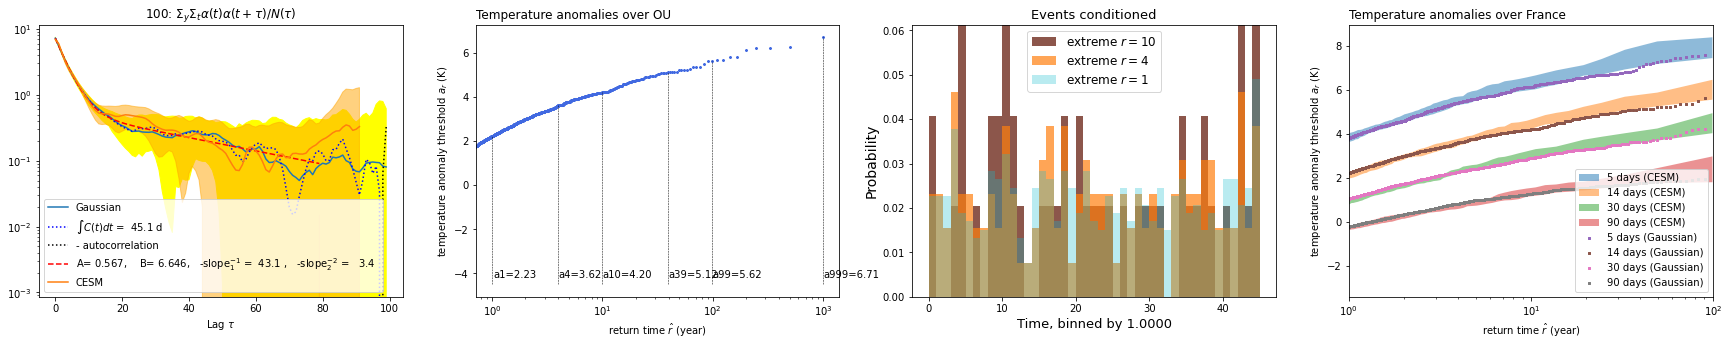

In [51]:
%%time
series_reshape = GaussianProcInstant(6.478, 3.4, 1e5,1000)+GaussianProcInstant(0.69, 38.6, 1e5,1000)
print("series.shape = ", series_reshape.shape)

Months1 = [0, 0, 0, 0, 0, 0, 0, 30, 30, 40, 0, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(itertools.accumulate(Months1))
period_label = '100'
FROM = 'CESM'
TO = 'OU'
area = 'France'
figure = plt.figure(1, figsize=(30, 5))
ax = figure.add_subplot(141)
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)
PltAutocorrelationFit(autocorr_mean,autocorr_std,0,80,ax,period_label)   
autocorr_mean = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_mean_JJA.npy')
autocorr_std = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_std_JJA.npy')
plt.fill_between(np.arange(0, len(autocorr_mean)), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='orange',alpha=0.5)
plt.plot(autocorr_mean,label=FROM)
plt.legend()

XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted = ProcTimeAverage(series_reshape,Tot_Mon1,'yes')
ax2 = figure.add_subplot(142)
ax3 = figure.add_subplot(143)
PltReturnsHist(XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted, Tot_Mon1,TO,ax2,ax3)

ax4 = figure.add_subplot(144)
#BootstrapReturnsOnly(series_reshape, area, Tot_Mon1, area, ax4)
Bootstraps(series_reshape,FROM,Tot_Mon1,area,ax4,'yes')

ax4.legend(loc='best')
figure.savefig("Images/autocorelation_2timescales_"+FROM+"_"+area+".png")
extent = ax4.get_window_extent().transformed(figure.dpi_scale_trans.inverted())
figure.savefig("Images/autocorelation_OU_"+FROM+"_"+area+".png", bbox_inches=extent.expanded(1.3, 1.3))

Below we manage to fit with a single time scale, although this is the case because the second time scale is relatively weak

np.mean(series)  =  -0.01885767 np.std(series) =  2.5472815
series.shape =  (1000, 100)
(10, 100)
(100,) (100,)
A.shape =  (1000, 87)
np.std(A) =  1.9159471873582432


../ERA/ERA_Fields.py:792: UserWarning: a_max_and_ti_postproc: adjusting length
  warnings.warn('a_max_and_ti_postproc: adjusting length')
../ERA/ERA_Fields.py:764: RuntimeWarning: divide by zero encountered in log
  r1 = - 1/(np.log(1 - m/len(D_sorted))) # assumption of Poisson process


T =  5
A.shape =  (1000, 96)
np.std(A) =  2.2828772984389567
T =  14
A.shape =  (1000, 87)
np.std(A) =  1.9159471873582432
T =  30
A.shape =  (1000, 71)
np.std(A) =  1.5210975360715644
T =  90
A.shape =  (1000, 11)
np.std(A) =  0.9850268302810625
CPU times: user 1.53 s, sys: 408 ms, total: 1.94 s
Wall time: 1.58 s


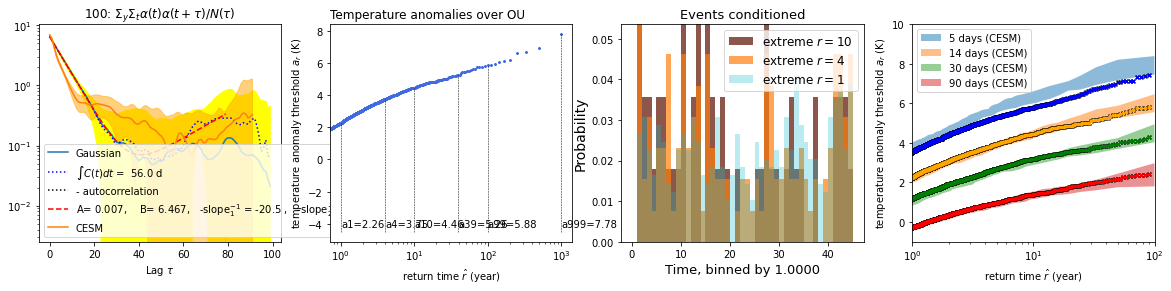

In [4]:
%%time
#series_reshape = GaussianProcInstant(6.478+0.69, 7, 1e5,1000)
series_reshape = GaussianProcInstant(6.478, 7, 1e5,1000)
print("series.shape = ", series_reshape.shape)

Months1 = [0, 0, 0, 0, 0, 0, 0, 30, 30, 40, 0, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(itertools.accumulate(Months1))
period_label = '100'
FROM = 'CESM'
TO = 'OU'
area = 'France'
figure = plt.figure(1, figsize=(20, 4))
ax = figure.add_subplot(141)
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)
PltAutocorrelationFit(autocorr_mean,autocorr_std,0,80,ax,period_label)   
autocorr_mean = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_mean_JJA.npy')
autocorr_std = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_std_JJA.npy')
plt.fill_between(np.arange(0, len(autocorr_mean)), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='orange',alpha=0.5)
plt.plot(autocorr_mean,label=FROM)
plt.legend()

XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted = ProcTimeAverage(series_reshape,Tot_Mon1,'yes')
ax2 = figure.add_subplot(142)
ax3 = figure.add_subplot(143)
PltReturnsHist(XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted, Tot_Mon1,TO,ax2,ax3)

ax4 = figure.add_subplot(144)
#BootstrapReturnsOnly(series_reshape, area, Tot_Mon1, area, ax4)
Bootstraps(series_reshape,FROM,Tot_Mon1,area,ax4,'yes')
ax4.legend(loc='best')
figure.savefig("Images/autocorelation_2timescales_"+FROM+"_"+area+".png")
extent = ax4.get_window_extent().transformed(figure.dpi_scale_trans.inverted())
figure.savefig("Images/autocorelation_OU_"+FROM+"_"+area+"_single_fit.png", bbox_inches=extent.expanded(1.4, 1.4),dpi=200)

# Scandinavia

np.mean(series)  =  -0.03102734 np.std(series) =  2.6635113
np.mean(series)  =  0.001065037 np.std(series) =  0.54498166
series.shape =  (1000, 100)
(10, 100)
(100,) (100,)
A.shape =  (1000, 87)
np.std(A) =  1.8626833299812862


../ERA/ERA_Fields.py:792: UserWarning: a_max_and_ti_postproc: adjusting length
  warnings.warn('a_max_and_ti_postproc: adjusting length')
../ERA/ERA_Fields.py:764: RuntimeWarning: divide by zero encountered in log
  r1 = - 1/(np.log(1 - m/len(D_sorted))) # assumption of Poisson process


T =  5
A.shape =  (1000, 96)
np.std(A) =  2.331272754542103
T =  14
A.shape =  (1000, 87)
np.std(A) =  1.8626833299812862
T =  30
A.shape =  (1000, 71)
np.std(A) =  1.4503549052129867
T =  90
A.shape =  (1000, 11)
np.std(A) =  0.9370705526586236
CPU times: user 1.65 s, sys: 373 ms, total: 2.02 s
Wall time: 1.7 s


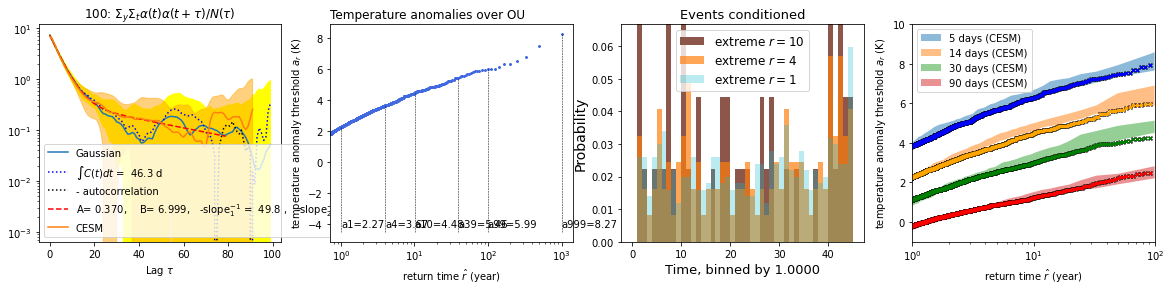

In [29]:
%%time
series_reshape = GaussianProcInstant(7.063, 4.6, 1e5,1000)+GaussianProcInstant(0.277, 79.9, 1e5,1000)
print("series.shape = ", series_reshape.shape)

Months1 = [0, 0, 0, 0, 0, 0, 0, 30, 30, 40, 0, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(itertools.accumulate(Months1))
period_label = '100'
FROM = 'CESM'
TO = 'OU'
area = 'Scandinavia'
figure = plt.figure(1, figsize=(20, 4))
ax = figure.add_subplot(141)
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)
PltAutocorrelationFit(autocorr_mean,autocorr_std,0,80,ax,period_label)   
autocorr_mean = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_mean_JJA.npy')
autocorr_std = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_std_JJA.npy')
plt.fill_between(np.arange(0, len(autocorr_mean)), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='orange',alpha=0.5)
plt.plot(autocorr_mean,label=FROM)
plt.legend()

XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted = ProcTimeAverage(series_reshape,Tot_Mon1,'yes')
ax2 = figure.add_subplot(142)
ax3 = figure.add_subplot(143)
PltReturnsHist(XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted, Tot_Mon1,TO,ax2,ax3)

ax4 = figure.add_subplot(144)
#BootstrapReturnsOnly(series_reshape, area, Tot_Mon1, area, ax4)
Bootstraps(series_reshape,FROM,Tot_Mon1,area,ax4,'yes')

ax4.legend(loc='best')
figure.savefig("Images/autocorelation_2timescales_"+FROM+"_"+area+".png")
extent = ax4.get_window_extent().transformed(figure.dpi_scale_trans.inverted())
figure.savefig("Images/autocorelation_OU_"+FROM+"_"+area+".png", bbox_inches=extent.expanded(1.4, 1.4),dpi=200)

np.mean(series)  =  0.0026413775 np.std(series) =  2.6721797
np.mean(series)  =  0.0040707137 np.std(series) =  0.522138
series.shape =  (1000, 100)
(10, 100)
(100,) (100,)
A.shape =  (1000, 87)
np.std(A) =  1.8590763193696105


../ERA/ERA_Fields.py:534: RuntimeWarning: divide by zero encountered in log
  r1 = - 1/(np.log(1 - m/len(D_sorted)))


T =  5
A.shape =  (1000, 96)
np.std(A) =  2.334981187007936
T =  14
A.shape =  (1000, 87)
np.std(A) =  1.8590763193696105
T =  30
A.shape =  (1000, 71)
np.std(A) =  1.4218273049252566
T =  90
A.shape =  (1000, 11)
np.std(A) =  0.9061090354539666
CPU times: user 1.5 s, sys: 20 ms, total: 1.52 s
Wall time: 1.6 s


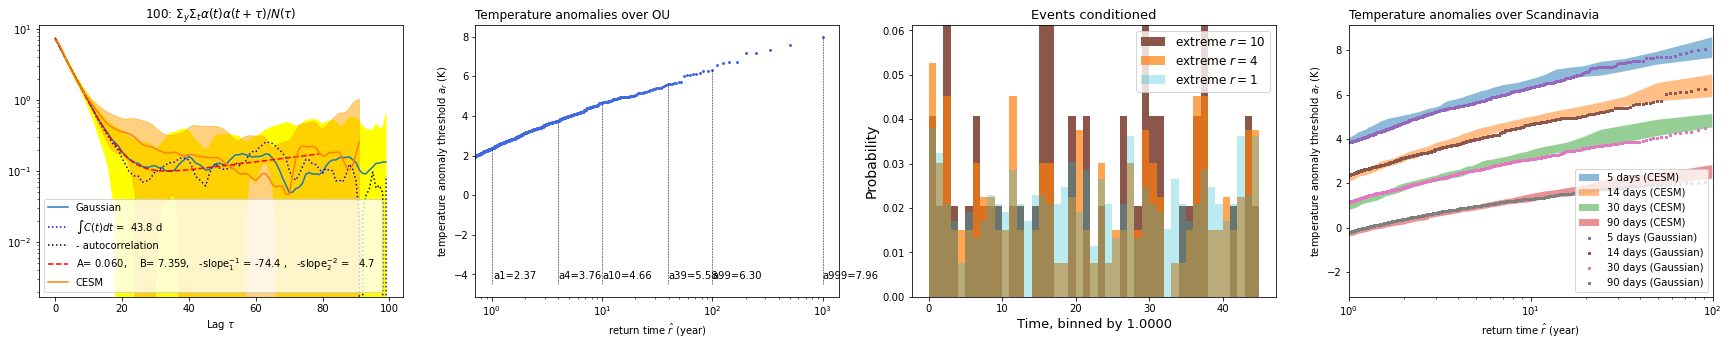

In [63]:
%%time
series_reshape = GaussianProcInstant(7.063, 4.6, 1e5,1000)+GaussianProcInstant(0.277, 79.9, 1e5,1000)
print("series.shape = ", series_reshape.shape)

Months1 = [0, 0, 0, 0, 0, 0, 0, 30, 30, 40, 0, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(itertools.accumulate(Months1))
period_label = '100'
FROM = 'CESM'
TO = 'OU'
area = 'Scandinavia'
figure = plt.figure(1, figsize=(30, 5))
ax = figure.add_subplot(141)
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)
PltAutocorrelationFit(autocorr_mean,autocorr_std,0,80,ax,period_label)   
autocorr_mean = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_mean_JJA.npy')
autocorr_std = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_std_JJA.npy')
plt.fill_between(np.arange(0, len(autocorr_mean)), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='orange',alpha=0.5)
plt.plot(autocorr_mean,label=FROM)
plt.legend()

XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted = ProcTimeAverage(series_reshape,Tot_Mon1,'yes')
ax2 = figure.add_subplot(142)
ax3 = figure.add_subplot(143)
PltReturnsHist(XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted, Tot_Mon1,TO,ax2,ax3)

ax4 = figure.add_subplot(144)
#BootstrapReturnsOnly(series_reshape, area, Tot_Mon1, area, ax4)
Bootstraps(series_reshape,FROM,Tot_Mon1,area,ax4,'yes')

ax4.legend(loc='best')
figure.savefig("Images/autocorelation_2timescales_"+FROM+"_"+area+".png")
extent = ax4.get_window_extent().transformed(figure.dpi_scale_trans.inverted())
figure.savefig("Images/autocorelation_OU_"+FROM+"_"+area+".png", bbox_inches=extent.expanded(1.3, 1.3))

# ERA5 trials

np.mean(series)  =  -0.008206929 np.std(series) =  2.4508753
np.mean(series)  =  0.017906943 np.std(series) =  0.67271
series.shape =  (1000, 100)
(10, 100)
(100,) (100,)
A.shape =  (1000, 87)
np.std(A) =  1.628489538505736
T =  5
A.shape =  (1000, 96)
np.std(A) =  2.099115744216076
T =  14
A.shape =  (1000, 87)
np.std(A) =  1.628489538505736
T =  30
A.shape =  (1000, 71)
np.std(A) =  1.2700516034338747
T =  90
A.shape =  (1000, 11)
np.std(A) =  0.8850329248103005
CPU times: user 17.3 s, sys: 2.65 s, total: 20 s
Wall time: 17.2 s


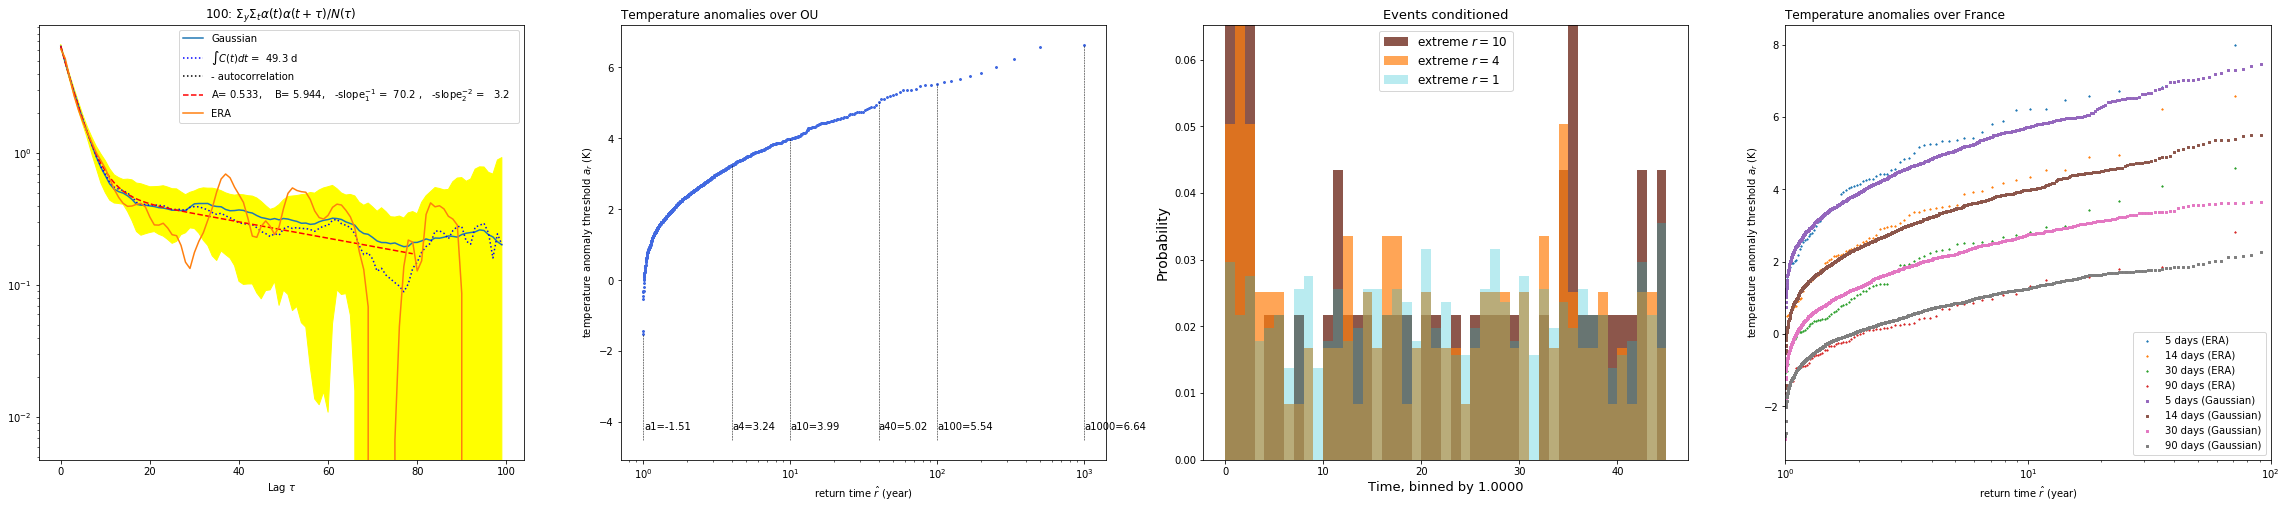

In [41]:
%%time
series_reshape = GaussianProcInstant(5.899, 3.4, 1e5,1000)+GaussianProcInstant(0.448, 107.8, 1e5,1000)
print("series.shape = ", series_reshape.shape)

Months1 = [0, 0, 0, 0, 0, 0, 0, 30, 30, 40, 0, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(itertools.accumulate(Months1))
period_label = '100'
FROM = 'ERA'
TO = 'OU'
area = 'France'
figure = plt.figure(1, figsize=(40, 8))
ax = figure.add_subplot(141)
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)
PltAutocorrelationFit(autocorr_mean,autocorr_std,0,80,ax,period_label)   
autocorr_mean = np.load('../'+FROM+'/Postproc/ERA_'+area+'_nonorm_auto_corr_JJA.npy')
plt.plot(autocorr_mean,label=FROM)
plt.legend()

XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted = ProcTimeAverage(series_reshape,Tot_Mon1)
ax2 = figure.add_subplot(142)
ax3 = figure.add_subplot(143)
PltReturnsHist(XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted, Tot_Mon1,TO,ax2,ax3)

ax4 = figure.add_subplot(144)
#BootstrapReturnsOnly(series_reshape, area, Tot_Mon1, area, ax4)
Returns(series_reshape,FROM,Tot_Mon1,area,ax4)
ax4.legend(loc='best')

np.mean(series)  =  0.029907996 np.std(series) =  2.2438738
np.mean(series)  =  0.0104614 np.std(series) =  0.6086184
series.shape =  (1000, 100)
(10, 100)
(100,) (100,)
A.shape =  (1000, 87)
np.std(A) =  1.6078880184878084
T =  5
A.shape =  (1000, 96)
np.std(A) =  2.0030692618801043
T =  14
A.shape =  (1000, 87)
np.std(A) =  1.6078880184878084
T =  30
A.shape =  (1000, 71)
np.std(A) =  1.2628665630798752
T =  90
A.shape =  (1000, 11)
np.std(A) =  0.875982484049896
CPU times: user 17.2 s, sys: 2.06 s, total: 19.3 s
Wall time: 17 s


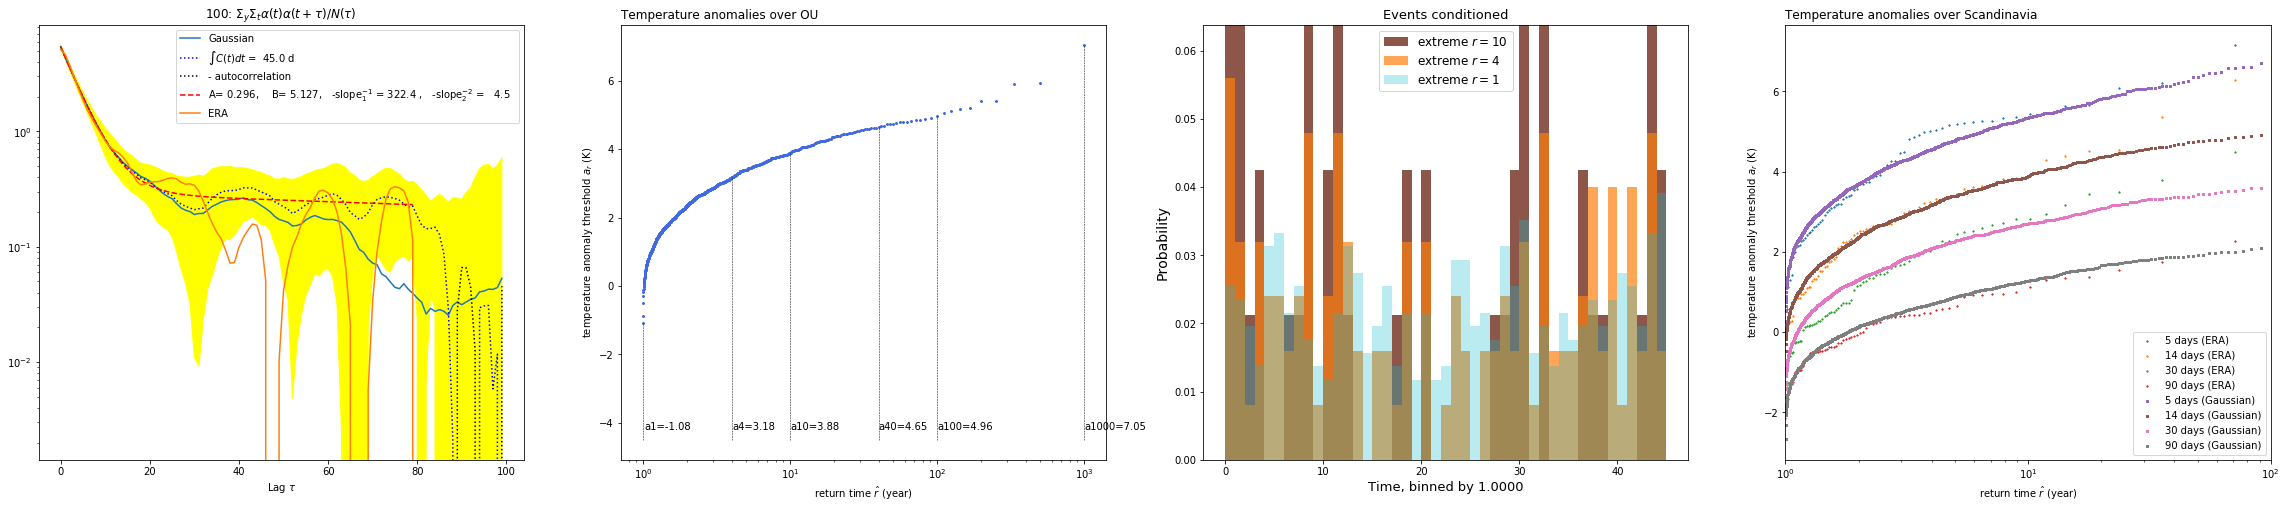

In [42]:
%%time
series_reshape = GaussianProcInstant(5.013, 4.5, 1e5,1000)+GaussianProcInstant(0.382, 61.9, 1e5,1000)
print("series.shape = ", series_reshape.shape)

Months1 = [0, 0, 0, 0, 0, 0, 0, 30, 30, 40, 0, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(itertools.accumulate(Months1))
period_label = '100'
FROM = 'ERA'
TO = 'OU'
area = 'Scandinavia'
figure = plt.figure(1, figsize=(40, 8))
ax = figure.add_subplot(141)
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)
PltAutocorrelationFit(autocorr_mean,autocorr_std,0,80,ax,period_label)   
autocorr_mean = np.load('../'+FROM+'/Postproc/ERA_'+area+'_nonorm_auto_corr_JJA.npy')
plt.plot(autocorr_mean,label=FROM)
plt.legend()

XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted = ProcTimeAverage(series_reshape,Tot_Mon1)
ax2 = figure.add_subplot(142)
ax3 = figure.add_subplot(143)
PltReturnsHist(XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted, Tot_Mon1,TO,ax2,ax3)

ax4 = figure.add_subplot(144)
#BootstrapReturnsOnly(series_reshape, area, Tot_Mon1, area, ax4)
Returns(series_reshape,FROM,Tot_Mon1,area,ax4)
ax4.legend(loc='best')

np.mean(series)  =  -0.008548387 np.std(series) =  2.4419656
np.mean(series)  =  -0.022697018 np.std(series) =  0.9300842
series.shape =  (1000, 100)
(10, 100)
(100,) (100,)
A.shape =  (1000, 87)
np.std(A) =  1.6977781720054321
T =  5
A.shape =  (1000, 96)
np.std(A) =  2.1616314019084237
T =  14
A.shape =  (1000, 87)
np.std(A) =  1.6977781720054321
T =  30
A.shape =  (1000, 71)
np.std(A) =  1.338698407555802
T =  90
A.shape =  (1000, 11)
np.std(A) =  0.8969674698918508
CPU times: user 18.2 s, sys: 3 s, total: 21.2 s
Wall time: 17.7 s


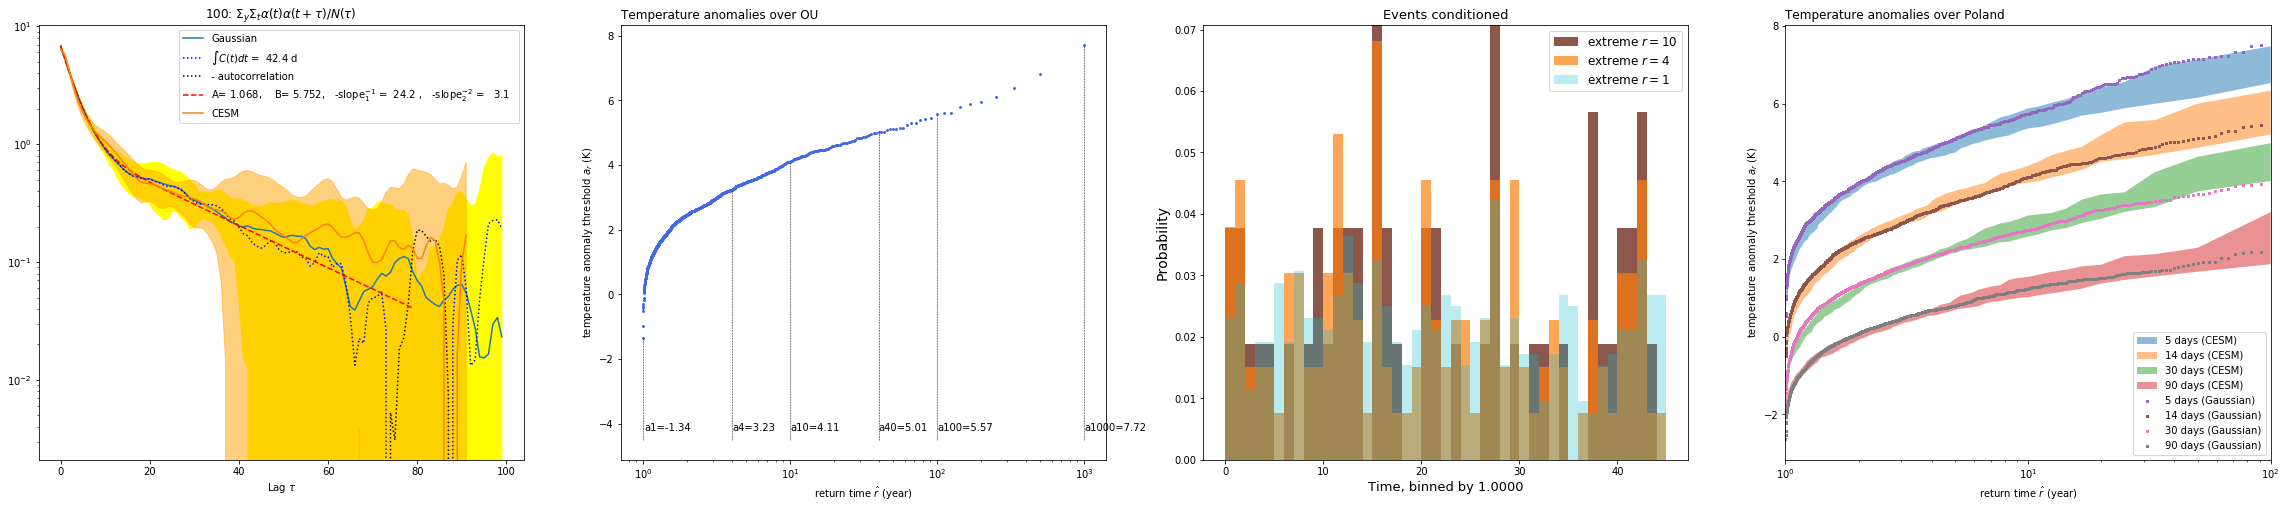

In [35]:
%%time
series_reshape = GaussianProcInstant(5.834, 3.3, 1e5,1000)+GaussianProcInstant(0.852, 34.8, 1e5,1000)
print("series.shape = ", series_reshape.shape)

Months1 = [0, 0, 0, 0, 0, 0, 0, 30, 30, 40, 0, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(itertools.accumulate(Months1))
period_label = '100'
FROM = 'CESM'
TO = 'OU'
area = 'Poland'
figure = plt.figure(1, figsize=(40, 8))
ax = figure.add_subplot(141)
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)
PltAutocorrelationFit(autocorr_mean,autocorr_std,0,80,ax,period_label)   
autocorr_mean = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_mean_JJA.npy')
autocorr_std = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_std_JJA.npy')
plt.fill_between(np.arange(0, len(autocorr_mean)), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='orange',alpha=0.5)
plt.plot(autocorr_mean,label=FROM)
plt.legend()

XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted = ProcTimeAverage(series_reshape,Tot_Mon1)
ax2 = figure.add_subplot(142)
ax3 = figure.add_subplot(143)
PltReturnsHist(XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted, Tot_Mon1,TO,ax2,ax3)

ax4 = figure.add_subplot(144)
#BootstrapReturnsOnly(series_reshape, area, Tot_Mon1, area, ax4)
Bootstraps(series_reshape,FROM,Tot_Mon1,area,ax4)
ax4.legend(loc='best')
figure.savefig("Images/autocorelation_2timescales_"+FROM+"_"+area+".png")
extent = ax4.get_window_extent().transformed(figure.dpi_scale_trans.inverted())
figure.savefig("Images/autocorelation_OU_"+FROM+"_"+area+".png", bbox_inches=extent.expanded(1.3, 1.3))

np.mean(series)  =  0.031960927 np.std(series) =  2.4052088
series.shape =  (1000, 100)
(10, 100)
(100,) (100,)
A.shape =  (1000, 87)
np.std(A) =  1.485529135621897
T =  5
A.shape =  (1000, 96)
np.std(A) =  1.9707946328454684
T =  14
A.shape =  (1000, 87)
np.std(A) =  1.485529135621897
T =  30
A.shape =  (1000, 71)
np.std(A) =  1.093832504879049
T =  90
A.shape =  (1000, 11)
np.std(A) =  0.6446893669697035
CPU times: user 8.91 s, sys: 443 ms, total: 9.35 s
Wall time: 8.77 s


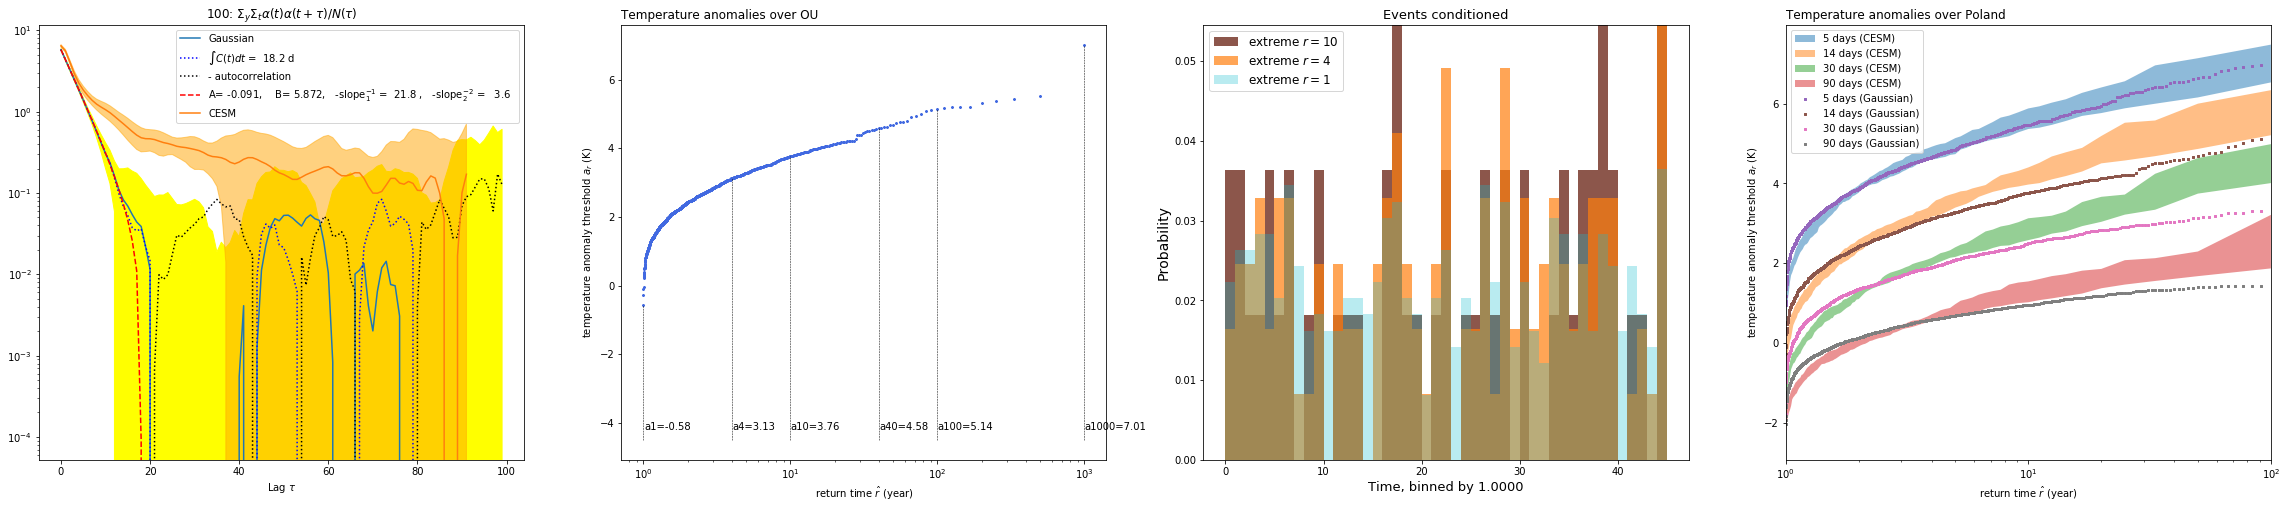

In [40]:
%%time
series_reshape = GaussianProcInstant(5.739, 3.6, 1e5,1000)
print("series.shape = ", series_reshape.shape)

Months1 = [0, 0, 0, 0, 0, 0, 0, 30, 30, 40, 0, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(itertools.accumulate(Months1))
period_label = '100'
FROM = 'CESM'
TO = 'OU'
area = 'Poland'
figure = plt.figure(1, figsize=(40, 8))
ax = figure.add_subplot(141)
autocorr_mean,autocorr_std = PltAutocorrelation(series_reshape,ax,period_label)
PltAutocorrelationFit(autocorr_mean,autocorr_std,0,80,ax,period_label)   
autocorr_mean = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_mean_JJA.npy')
autocorr_std = np.load('../'+FROM+'/Postproc/CESM_'+area+'_nonorm_autocorr_std_JJA.npy')
plt.fill_between(np.arange(0, len(autocorr_mean)), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='orange',alpha=0.5)
plt.plot(autocorr_mean,label=FROM)
plt.legend()

XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted = ProcTimeAverage(series_reshape,Tot_Mon1)
ax2 = figure.add_subplot(142)
ax3 = figure.add_subplot(143)
PltReturnsHist(XX_rt, YY_rt, xx_rt, yy_rt, A_max_sorted, Tot_Mon1,TO,ax2,ax3)

ax4 = figure.add_subplot(144)
#BootstrapReturnsOnly(series_reshape, area, Tot_Mon1, area, ax4)
Bootstraps(series_reshape,FROM,Tot_Mon1,area,ax4)
ax4.legend(loc='best')
#figure.savefig("Images/autocorelation_2timescales_"+FROM+"_"+area+".png")
#extent = ax4.get_window_extent().transformed(figure.dpi_scale_trans.inverted())
#figure.savefig("Images/autocorelation_OU_"+FROM+"_"+area+".png", bbox_inches=extent.expanded(1.3, 1.3))